#### Abstration
This Jupyter Notebook is my humble attempt to explore the house prices dataset, and try to build a gradient boosting tree model using __train.csv__ to predict the __Saleprice__ target variable with features from __test.csv__. Many of the visualization and modelling techniques are inspired by other popular kernels on Kaggle. 

### 0. Load essential libraries

In [1]:
# System Libraries
import math

# Data analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
%matplotlib inline

# Machine Learning tools
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures

# Gradient boosting library
from xgboost import XGBRegressor

### 1. Data loading
Raw data are loaded into __raw_data__ and __raw_predict__, they are then copied into __data__ and __data_predict__ for further manipulation.

In [2]:
# Load files to dataframes
raw_data = pd.read_csv('./data/train.csv')
raw_predict = pd.read_csv('./data/test.csv')

# Copy raw data into variables
data = raw_data.copy()
data_predict = raw_predict.copy()

In [3]:
# Make sure data is loaded correctly
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
data_predict.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


### 2. Data exploration

#### 2.1 Dataframe description
From the dataframe description shown below, there are several observations
* There are one more column in training set than the predicting set, which is the target variable __salesprice__.
* The numeric values look fine, all the values are > 0 as they should be.
* There are __missing values__ in some columns, we need to deal with them correctly to optimize the model performance. Possible strategies are: 
    - Transform the data using imputation (mean, median, mode)
    - Replace the missing values with missing labels
    - Remove the column with lots of missing values
    - Remove the observations with many missing columns
    - Deduce the value from other columns in the same rows
* Among the columns of __object__ type, __Neighborhood__ has the most unique values, which is __25__. This tells us we don't need to worry too much if we use __get_dummies__. 
    - __top__ and __freq__ tell use the most frequent value of the object type columns and its frequency.

In [5]:
data.set_index('Id', inplace=True);
data_predict.set_index('Id', inplace=True);

In [6]:
comment = 'There are {} observations and {} columns in {}.'
print(comment.format(data.shape[0], data.shape[1], 'training set'))
print(comment.format(data_predict.shape[0], data_predict.shape[1], 'predicting set'))

There are 1460 observations and 80 columns in training set.
There are 1459 observations and 79 columns in predicting set.


In [7]:
data.describe(include='all')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,

### 3. Data Cleansing
After inspecting every column manually in the excel, it can be observed most of the missing values exist on purpose. 

For example, a NA in __PoolQC__ or __Fence__ columns may simply mean that the house does not have a Pool or Fence with it. One row may have NA values in  __GarageType__, __GarageYrBlt__, __GarageQual__ and __GarageFinish__ at the same time, and that may mean that the house does not have a Garage. Rows with NA values in __FireplaceQu(Fire place quality)__ column always have 0 __Fireplaces__ because there are no fireplaces in the house so the quality is missing.

There are also columns such as __MasVnrType__, that there are __None__ and __NA__ at the same time. In this case, NA should be replaced by 'None' because they are the same thing.

Based on my observation on the data, I applied the following strategy on dealing with the missing values.

For the __numeric columns__, I attempted to fill in __0__ to replace the missing values. I assume the values are 0 if they are missing.  

For the __categorical columns__, I attempted to use a string __'None'__ to replace the missing values. Since the categorical columns are then applied with the __get_dummies__ method, and using __'None'__ does not incur any information loss.

Simple is the best.

In [8]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


In [9]:
data.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
# Fill in missing data for training and predicting dataset
data._get_numeric_data().fillna(0, inplace=True);
data_predict._get_numeric_data().fillna(0, inplace=True);
for column in data.select_dtypes(include='object').columns:
    data[column].fillna('None', inplace=True)
    data_predict[column].fillna('None', inplace=True)

In [11]:
# convert all object type columns to category to save memory
data_ram_usage = round(data.memory_usage(deep=True).sum()/1024, 2)
predict_ram_usage = round(data_predict.memory_usage(deep=True).sum()/1024, 2)
for column in data.select_dtypes('object').columns:
    data[column] = data[column].astype('category')
    data_predict[column] = data_predict[column].astype('category')
data_ram_usage_after = round(data.memory_usage(deep=True).sum()/1024, 2)
predict_ram_usage_after = round(data_predict.memory_usage(deep=True).sum()/1024, 2)

comment = '{} set memory usage decreases from {} KB to {} KB after converting data type'
print(comment.format('Testing', data_ram_usage, data_ram_usage_after))
print(comment.format('Predicting', predict_ram_usage, predict_ram_usage_after))

Testing set memory usage decreases from 4171.61 KB to 519.84 KB after converting data type
Predicting set memory usage decreases from 4157.58 KB to 506.99 KB after converting data type


### 4. Feature Selection

#### 4.1 Correlation Selection using Correlation Heatmap
A correlation Heatmap can be used to have a sense about which __numeric__ features are correlated to the target variable Saleprice. Based on the observation, we may perform feature selection and remove the columns whose correlations are below certain threshold away.

Forcusing on the last row of the correlation heatmap below, we can see that some of the features are typically strongly related to __Saleprice__, such as __OverallQual, GrLivArea, GarageYrBlt, GarageCaras, GarageArea__. 

A second heatmap with only features whose correlations with SalePrice are larger than __0.30__ was then created, which includes __18 selected features.__

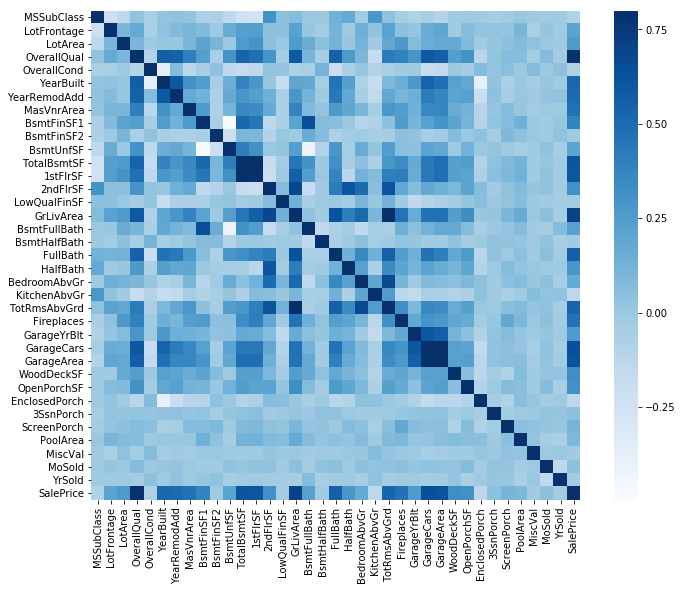

In [12]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, cmap="Blues", square=True);

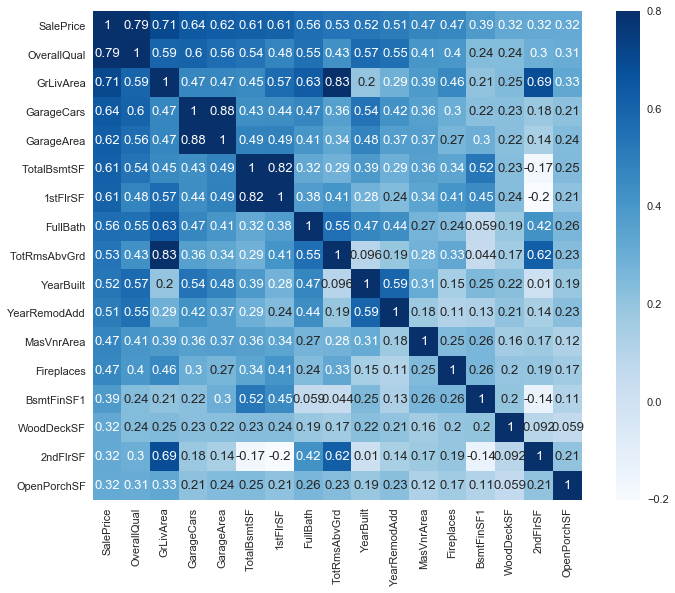

In [13]:
# keep features above certain threshold 
threshold = 0.3
sorted_abs_corr = abs(corrmat['SalePrice']).sort_values(ascending=False)
numeric_features = sorted_abs_corr.index
selected_features = [numeric_features[index] for index, corr in enumerate(sorted_abs_corr)\
                     if corr > threshold]

# correlation matrix for features below threshold
cm = data[selected_features].corr()

#saleprice correlation matrix
sns.set(font_scale=1.1)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cm, vmax=.8, cmap="Blues", annot=True, square=True);

#### 4.2 Feature Selection after get_dummies
It is not feasible to plot the correlation heatmap after applying __get_dummies__ function to the dataset, because there will be __304__ features in total and the new heatmap will be uninterpretable. However, we can still apply the correlation threshold method to the newly created features and see how many features have __> 0.3__ correlation with Saleprice. 

It turns out that there are __44__ features which has correlation __> 0.3__ with Saleprice. get_dummies are doing its job!

In [14]:
data_predict['SalePrice'] = 0
frames = [data, data_predict]

result = pd.concat(frames)
result = pd.get_dummies(result)

data = result.iloc[0:1460]
data_predict = result.iloc[1460:]
del data_predict['SalePrice']

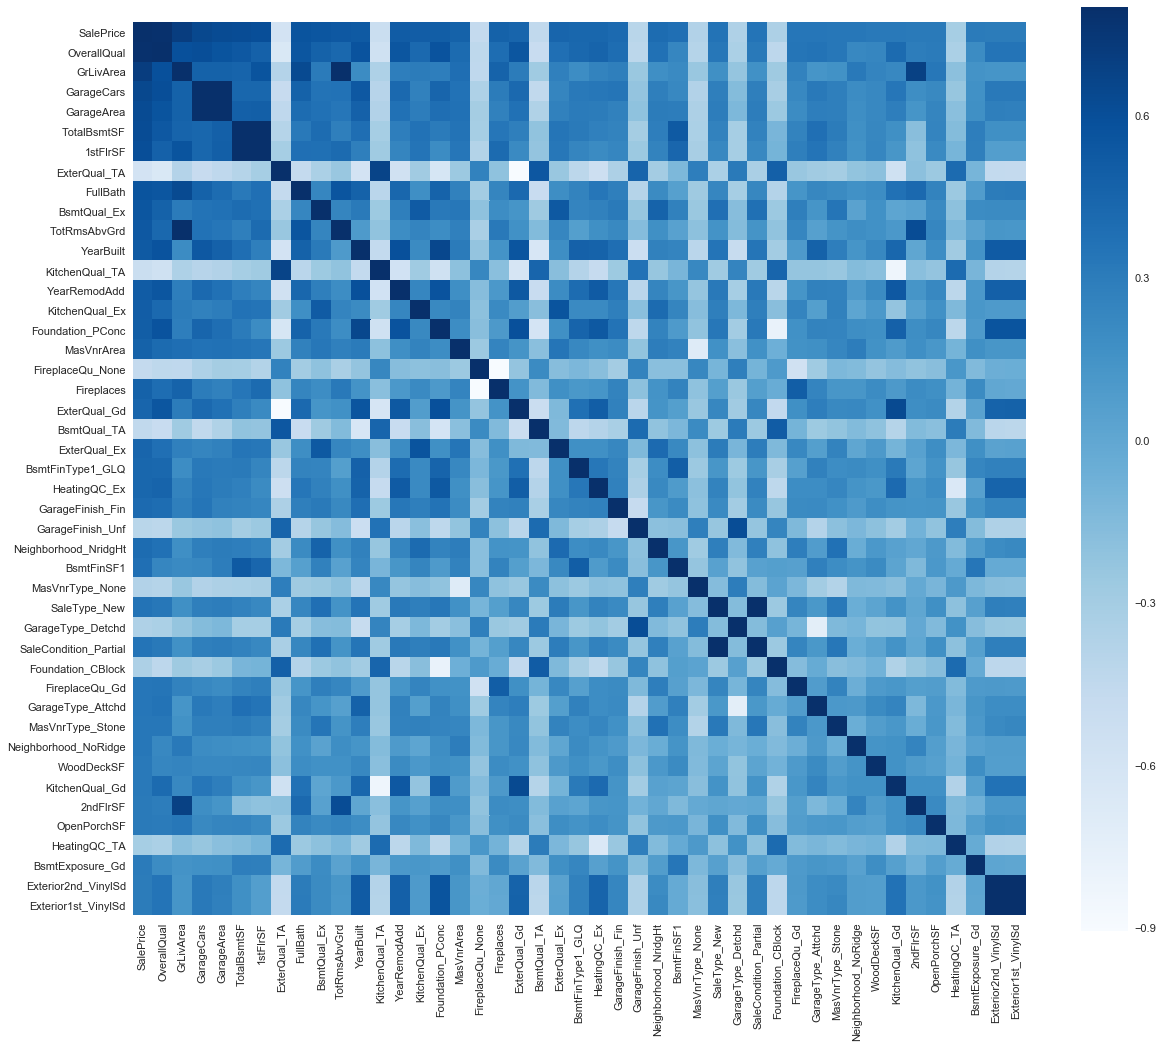

In [15]:
# new correlation matrix
corrmat = data.corr()

# keep features above certain threshold 
threshold = 0.3
sorted_abs_corr = abs(corrmat['SalePrice']).sort_values(ascending=False)
numeric_features = sorted_abs_corr.index
selected_features = [numeric_features[index] for index, corr in enumerate(sorted_abs_corr)\
                     if corr > threshold]


# correlation matrix for features below threshold
cm = data[selected_features].corr()

#saleprice correlation matrix
f, ax = plt.subplots(figsize=(20, 17))
sns.heatmap(cm, vmax=.8, cmap="Blues", square=True);

In [16]:
# Remove SalePrice from selected_features so it can be used later
selected_features.remove('SalePrice')

#### 4.3 Feature Selection with Ridge regression (To be implemented)
Another popular way to perform feature selection is to use the __ridge regression__ to perform automatic feature selection. Features which the model thinks are insignificant will be assigned low or even zero weight to the model. Features with significance under certain threshold can be removed.

### 5. Model Construction
Finally, here comes the model construction section. I have tried to run models under 4 different combinations, they are:
* XGBoost tree of 1000 estimators with all features
* Random forest tree of 1000 estimators with all features
* XGBoost tree of 1000 estimators with 44 selected features
* Random forest tree of 1000 estimators with 44 selected features
* XGBoost tree of 1000 estimators with Polynomial features of the 44 selected features.

It can be seen from the learning curve that the first model, __XGBoost tree of 1000 estimators with all features__ is delivering the best cross-validation performance. We can see that the training error and the cross-validation error curves are converging but they are not yet intersected, this tells us that the model is __underfitting__ and further improvements are possible. Possible solutions are:
* Get more datasets for training
* Increase the complexity of model by hypertuning the parameters or try other models

In [17]:
# Split the traning and testing data
train_data = data.copy()
features = train_data.loc[:, data.columns != 'SalePrice']
target = train_data.loc[:, 'SalePrice']
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [18]:
# The learning curve which is used to spot variance and bias problems
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("N (Training Set Sizes)")
    plt.ylabel("Mean Square Log Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        scoring=make_scorer(mean_squared_log_error), train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    plt.grid()
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Victor\\Anaconda2\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

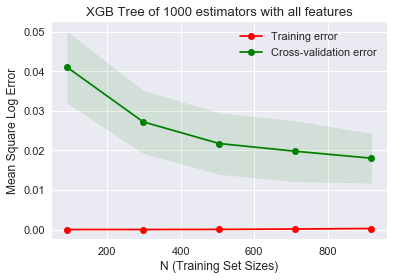

In [19]:
model = XGBRegressor(n_estimators=1000)
title = "XGB Tree of 1000 estimators with all features"
plot_learning_curve(model, title, X_train, y_train, cv=10, n_jobs=-1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Victor\\Anaconda2\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

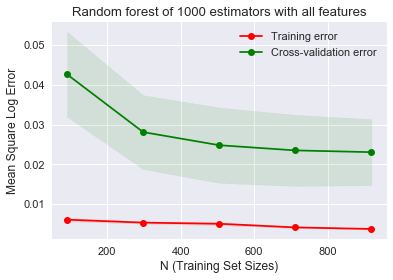

In [20]:
rf_r = RandomForestRegressor(n_estimators=1000, n_jobs=4)
title = "Random forest of 1000 estimators with all features"
plot_learning_curve(rf_r, title, X_train, y_train, cv=10, n_jobs=-1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Victor\\Anaconda2\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

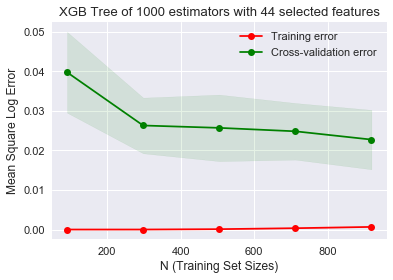

In [21]:
model = XGBRegressor(n_estimators=1000)
title = "XGB Tree of 1000 estimators with {} selected features".format(len(selected_features))
plot_learning_curve(model, title, X_train[selected_features], y_train, cv=10, n_jobs=-1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Victor\\Anaconda2\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

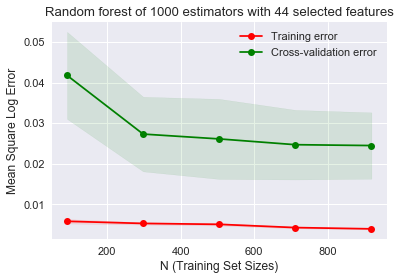

In [22]:
rf_r = RandomForestRegressor(n_estimators=1000, n_jobs=4)
title = "Random forest of 1000 estimators with {} selected features".format(len(selected_features))
plot_learning_curve(rf_r, title, X_train[selected_features], y_train, cv=10, n_jobs=-1)

<module 'matplotlib.pyplot' from 'C:\\Users\\Victor\\Anaconda2\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

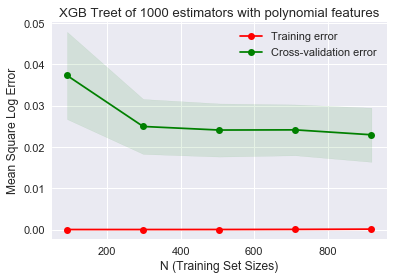

In [23]:
model = XGBRegressor(n_estimators=1000)
rf_r = RandomForestRegressor(n_estimators=50, n_jobs=4)

poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train[selected_features])

title = "XGB Treet of 1000 estimators with polynomial features".format(len(selected_features))
plot_learning_curve(model, title, X_train_transformed, y_train, cv=10, n_jobs=-1)

### 5. Conclusion
Since the first model, __XGBoost tree of 1000 estimators with all features__ is giving us the best result. I will retrain the model with the whole dataset and make final prediction. My first attempt ranked at __1936__ with a score of __0.13657__. There are still many improvements that can be done, and that is the beauty of working as a data scientist.
If the machine learning model is for production, the __XGBoost tree trained with 44 selected features__ can be considerred, if using fewer features and sacrificing slight accuracy can provide us with much better performance.
![image.png](./img/image.png)

In [24]:
model = XGBRegressor(n_estimators=1000)
model.fit(features, target)
my_prediction = model.predict(data_predict)

In [25]:
result_frame = {'Id': data_predict.index, 'SalePrice': my_prediction}
result_df = pd.DataFrame(result_frame)
result_df.to_csv('./my_submission.csv', index=False)

#### Reference:
#### Marcelino, P. (2017, February). Comprehensive data exploration with Python | Kaggle. Retrieved May 7, 2018, from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python